<hr style="border:2px solid #0176DE"> </hr>
<center><h1 style="color:#173F8A;"> Escuela de Verano en Metodos Iterativos</h1></center> 
<center><h1 style="color:#173F8A;"> EMI 2024 - CMM Chile</h1></center>
<hr style="border:2px solid #0176DE"> </hr>
<h3 style="color:#173F8A;text-align:right;"> Profesores: &nbsp;Nicolás Barnafi<br>Manuel A. Sanchez<br></h3>

<h3 style="color:#03122E;text-align:right;"> 
    Centro de Modelamiento Matematico <br> 
    Instituto de Ingenieria Matematica y Computacional - IMC UC<br>  
</h3>

<hr style="border:2px solid #03122E"> </hr>
<center><h1 style="color:#173F8A;"> Modulo 1: Introducción</h1></center> 
<hr style="border:2px solid #03122E"> </hr>

<!-- Palette colors UC:
Primaria: 
celeste:#0176DE, azul #173F8A, azul oscuro: #03122E, amarillo: #FEC60D, amarillo oscuro: #E3AE00 
Secundaria
gris oscuro: #707070
-->

- The motivation

  3D simulations, HPC

- The actual motivation

  Upscale simulations, black-box never works

# The only requirement: Weak formulations

$$ -\Delta u = f \quad \Leftrightarrow \quad \int \nabla u \cdot \nabla v\,dx = \int f v\,dx \quad \forall v \in V_0$$

# Motivation problem: CFD

$$ \begin{aligned}-\Delta u + \nabla p = f\\ \mathrm{div}\, u = 0\end{aligned} \Leftrightarrow \begin{aligned}\int \nabla u\cdot \nabla v\,dx + \int p\, \mathrm{div}\, v\,dx && \forall v\in V \\ \int q \,\mathrm{div}\, u \,dx = 0 &&\forall q \in Q \end{aligned} \Leftrightarrow \begin{bmatrix} \mathbf{A} & \mathbf{B}^T \\ \mathbf{B} & \mathbf{0} \end{bmatrix}\begin{bmatrix} \mathbf{U} \\ \mathbf{P} \end{bmatrix} = \begin{bmatrix} \mathbf{F} \\ \mathbf{0} \end{bmatrix}$$

In [56]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
import scipy.sparse as sp
import matplotlib.pylab as plt

# Define geometry
#shape = Rectangle(2,0.41).Circle(0.2,0.2,0.05).Reverse().Face()
shape = Rectangle(2,0.41).Face()
shape.edges.name="wall"
shape.edges.Min(X).name="inlet"
shape.edges.Max(X).name="outlet"
geo = OCCGeometry(shape, dim=2)
Draw (shape);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

In [57]:
# Approximate geometry with a mesh
mesh = Mesh(geo.GenerateMesh(maxh=1))
#mesh.Curve(1)
Draw (mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [58]:
V = VectorH1(mesh, order=2, dirichlet="wall|inlet|cyl")
Q = H1(mesh, order=1)
X = V*Q
(u,p),(v,q) = X.TnT()

stokes = InnerProduct(Grad(u), Grad(v))*dx + div(u)*q*dx + div(v)*p*dx
a = BilinearForm(stokes)
f = LinearForm(v[0]*dx)
gf = GridFunction(X)
gfu, gfp = gf.components

uin = CF( (1.5*4*y*(0.41-y)/(0.41*0.41), 0) )
gfu.Set(uin, definedon=mesh.Boundaries("inlet"))
Draw(gfu, mesh, min=0, max=2)
SetVisualization(max=2)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

In [60]:
# Assembly operations do pending communication
a.Assemble()
f.Assemble()
res = f.vec -a.mat * gf.vec
inv = a.mat.Inverse(freedofs=X.FreeDofs(), inverse="umfpack")
gf.vec.data += inv * res
Draw(gfu)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.23…

BaseWebGuiScene

In [61]:
# Now we compute the nonzeros in the LU factorization
from scipy.sparse.linalg import splu
rows,cols,vals = a.mat.COO()
nnzA = len(vals)
A = sp.csr_matrix((vals,(rows,cols))) # NGSolve mat to scipy.sparse
LU = splu(A)
nnzs = LU.L.nnz + LU.U.nnz
print("Number of non-zeros of A:", nnzA)
print("Number of non-zeros of L+U:", nnzs)
print("Ratio of non-zeros:", len(vals)/nnzs)

Number of non-zeros of A: 1191
Number of non-zeros of L+U: 1542
Ratio of non-zeros: 0.7723735408560312


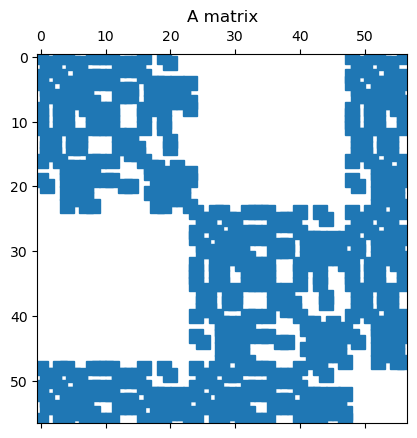

In [64]:
# Spy arrays
plt.spy(A)
plt.title("A matrix")
plt.show()

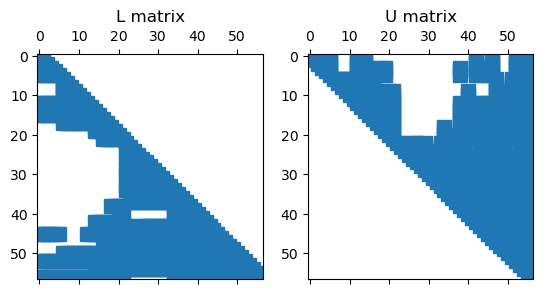

In [63]:
plt.subplot(1,2,1)
plt.spy(LU.L)
plt.title("L matrix")
plt.subplot(1,2,2)
plt.spy(LU.U)
plt.title("U matrix")
plt.show()

In [65]:
def convertToMb(nval):
    # 8 bytes per val 
    return nval * 8 * 1e-6
    
def computeNonzeros(maxh):
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    mesh.Curve(3)
    V = VectorH1(mesh, order=2, dirichlet="wall|inlet|cyl")
    Q = H1(mesh, order=1)
    X = V*Q
    (u,p),(v,q) = X.TnT()
    
    stokes = InnerProduct(Grad(u), Grad(v))*dx + div(u)*q*dx + div(v)*p*dx
    a = BilinearForm(stokes)
    a.Assemble()
    rows,cols,vals = a.mat.COO()
    nnzA = len(vals)
    
    import scipy.sparse as sp
    A = sp.csr_matrix((vals,(rows,cols)))
    from scipy.sparse.linalg import splu # Sparse LU
    
    LU= splu(A)
    nnzs = LU.L.nnz + LU.U.nnz
    print("Number of non-zeros of A:", nnzA, "(in {:1.3f} Mb)".format(convertToMb(nnzA)))
    print("Number of non-zeros of L+U:", nnzs, "(in {:1.3f} Mb)".format(convertToMb(nnzs)))
    print("Ratio A.nnz / LU.nnz:", nnzA/nnzs)
    return nnzA, nnzs

In [66]:
for h in [0.1, 0.05, 0.01, 0.005]:
    print(f"========= Using h={h:1.3f}")
    nnza, nnzlu = computeNonzeros(h)

========= Using h=0.100
Number of non-zeros of A: 24024 (in 0.192 Mb)
Number of non-zeros of L+U: 75885 (in 0.607 Mb)
Ratio A.nnz / LU.nnz: 0.3165843051986559
========= Using h=0.050
Number of non-zeros of A: 103041 (in 0.824 Mb)
Number of non-zeros of L+U: 642200 (in 5.138 Mb)
Ratio A.nnz / LU.nnz: 0.16045001557147306
========= Using h=0.010
Number of non-zeros of A: 2532409 (in 20.259 Mb)
Number of non-zeros of L+U: 57359050 (in 458.872 Mb)
Ratio A.nnz / LU.nnz: 0.04415012103582608


In [67]:
from time import perf_counter
def solveDirect(maxh):
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    mesh.Curve(3)
    V = VectorH1(mesh, order=1, dirichlet="wall|inlet|cyl")
    Q = H1(mesh, order=1)
    X = V*Q
    (u,p),(v,q) = X.TnT()
    
    stokes = InnerProduct(Grad(u), Grad(v))*dx + div(u)*q*dx + div(v)*p*dx -0.1*h*h*grad(p)*grad(q)*dx
    #stokes = InnerProduct(Grad(u), Grad(v))*dx
    a = BilinearForm(stokes)
    f = LinearForm(v[0]*dx)
    gf = GridFunction(X)
    gfu, gfp = gf.components
    
    uin = CF( (1.5*4*y*(0.41-y)/(0.41*0.41), 0) )
    
    gfu.Set(uin, definedon=mesh.Boundaries("inlet"))
    a.Assemble()
    f.Assemble()
    t0 = perf_counter()
    inv = a.mat.Inverse(inverse="umfpack")
    gf.vec.data += inv * f.vec
    tf = perf_counter() - t0
    return tf

def solveIterative(maxh):
    mesh = Mesh(geo.GenerateMesh(maxh=maxh))
    mesh.Curve(3)
    V = VectorH1(mesh, order=1, dirichlet="wall|inlet|cyl")
    Q = H1(mesh, order=1)
    
    u,v = V.TnT()
    p,q = Q.TnT()

    
    a = BilinearForm(InnerProduct(Grad(u),Grad(v))*dx, symmetric=True)
    b = BilinearForm(div(u)*q*dx).Assemble()
    h = specialcf.mesh_size
    c = BilinearForm(-0.1*h*h*grad(p)*grad(q)*dx, symmetric=True).Assemble()
    
    mp = BilinearForm(p*q*dx, symmetric=True)
    f = LinearForm(V).Assemble()
    g = LinearForm(Q).Assemble();
    gfu = GridFunction(V, name="u")
    gfp = GridFunction(Q, name="p")
    uin = CoefficientFunction( (1.5*4*y*(0.41-y)/(0.41*0.41), 0) )
    gfu.Set(uin, definedon=mesh.Boundaries("inlet"))
    
    
    Qjacobi = Preconditioner(mp, "local")
    Amg = Preconditioner(a, "bddc")
    a.Assemble()
    mp.Assemble()
    K = BlockMatrix( [ [a.mat, b.mat.T], [b.mat, c.mat] ] )
    C = BlockMatrix( [ [Amg.mat, None], [None, Qjacobi.mat] ] )
    #C = BlockMatrix( [ [a.mat.Inverse(freedofs=V.FreeDofs()), None], [None, mp.mat.Inverse()] ] )
    
    rhs = BlockVector ( [f.vec, g.vec] )
    sol = BlockVector( [gfu.vec, gfp.vec] )
    t0 = perf_counter()
    solvers.MinRes (mat=K, pre=C, rhs=rhs, sol=sol, printrates='\r', initialize=False, maxsteps=500);
    
    tf = perf_counter() - t0
    return tf


In [68]:
maxh = 0.01
tfds = []
tfis = []
maxhs = [0.1, 0.05, 0.025, 0.0125]
for maxh in maxhs:
    print(f"========= Solving for h={maxh:1.3f}")
    tfd = solveDirect(maxh)
    tfi = solveIterative(maxh)
    tfis.append(tfi)
    tfds.append(tfd)
    print(f"Direct: {tfd:1.3f}s, Iterative: {tfi:1.3f}s")

========= Solving for h=0.100
LinearSolver converged in 50 iterations to residual 1.345756395583219e-07
Direct: 0.005s, Iterative: 0.029s
========= Solving for h=0.050
LinearSolver converged in 57 iterations to residual 2.8471198902939154e-07
Direct: 0.020s, Iterative: 0.068s
========= Solving for h=0.025
LinearSolver converged in 59 iterations to residual 5.387855818683863e-07
Direct: 0.113s, Iterative: 0.263s
========= Solving for h=0.013
LinearSolver converged in 59 iterations to residual 5.61594279071306e-07
Direct: 0.524s, Iterative: 0.878s


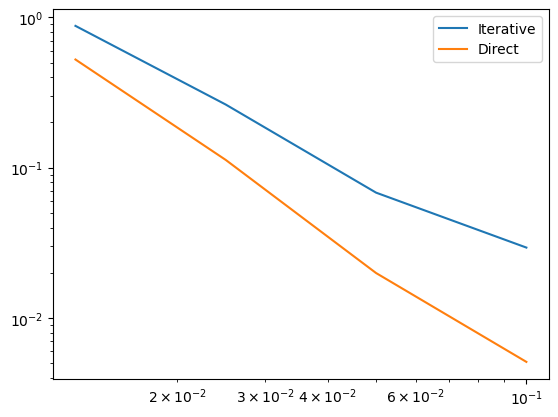

In [69]:
plt.loglog(maxhs, tfis, label="Iterative")
plt.loglog(maxhs, tfds, label="Direct")
plt.legend()
plt.show()

# Wrap up
- Direct methods have very limited scalability (_fill in_)
- Iterative methods overcome this but are more difficult
- We will understand this better by the end of tomorrow :)